In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random 
import pickle
from matplotlib.pyplot import figure
from tqdm import tqdm

from stoc_match import StochasticMatching, Aggregation

# System and settings

In [2]:
verteces = ['A', 'B', 'C', 'D']


#graph = {
#    'A': [('B', 70), ('C', 10), ('D', 50)],
#    'B': [('A', 70), ('D', 20)],
#    'C': [('A', 10), ('D', 5)],
#    'D': [('A', 50), ('B', 20), ('C', 5)]
#}


graph = {
    'A': [('B', 200), ('C', 10), ('D', 50)],
    'B': [('A', 200), ('D', 20)],
    'C': [('A', 10), ('D', 1)],
    'D': [('A', 50), ('B', 20), ('C', 1)]
}

arrival_rates = {
    'A': 0.9,
    'B': 0.2,
    'C': 0.5,
    'D': 0.6
}

arrival_rates_ind = {}
for ind, vertex in zip(list(range(len(arrival_rates))), arrival_rates.keys()):
    arrival_rates_ind[ind] = arrival_rates[vertex]

    
verteces_ind = {'A': 0,
               'B': 1,
               'C': 2,
               'D': 3
               }


eta = 0.5
discount = 0.8
#repeat = 10
#steps = 100
H = 50
k = 10

#experts = ['match_the_longest', 'probability_match_02']#, 'probability_match_02', 'probability_match_08']
experts = ['match_the_longest', 'edge_priority_match_reward', 'random_match']#, 'edge_priority_match_arrival_rate_low']
#experts = ['match_the_longest', 'edge_priority_match_1', 'edge_priority_match_2', 'edge_priority_match_random']
# 'edge_priority_arbitrary', 
queue_max = 5

queues ={v: [] for v in verteces}


state_space = list(itertools.product(np.array(range(queue_max + 1)), repeat=len(graph.keys())))

n = 0
state_space_ind = {}
for s in state_space:
    state_space_ind[str(n)] = s
    n += 1 
    
exp_ind = {}
n = 0
for exp in experts:
    exp_ind[str(n)] = exp
    n += 1 
    
prob_arrival = []
N =np.sum(np.array(list(arrival_rates.values())))

for rate in arrival_rates.values():
    prob_arrival.append(rate/N) 
    
num_states = len(state_space)
num_exp = len(experts)

edges = [(u, v, w) for u in graph for v, w in graph[u]]
edges_list = []

    
rewards_ind = {}

for edge in edges:
    e=[]
    e.append(verteces_ind[np.array(edge)[0]])
    e.append(verteces_ind[np.array(edge)[1]])
    if [verteces_ind[np.array(edge)[1]], verteces_ind[np.array(edge)[0]]] not in edges_list:
        edges_list.append(e)
        rewards_ind[str(e)] = edge[2]
    
num_actions = len(edges_list) + 1

state_action_space_ind = {}
n = 0
for s in state_space:
    for a in edges_list:
        state_action_space_ind[str(n)] = [s, a]
        n += 1 

key_list = list(state_space_ind.keys())
val_list = list(state_space_ind.values())

num_experts = len(experts)    

edges_ind = {}

for edge, i in zip(edges_list, list(range(len(edges_list)))):
    edges_ind[i] = edge
edges_ind[len(edges_list)] = 'no_move'

### Policies

In [6]:
def match_the_longest(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (np.array(state)[edge[0]] + np.array(state)[edge[1]]) > edge_max: 
                edge_max = np.array(state)[edge[0]] + np.array(state)[edge[1]]
                selected_edges = []
                selected_edges.append(edge)
            #elif np.array(state)[edge[0]] + np.array(state)[edge[1]] == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_reward(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if rewards_ind[str(edge)] > edge_max: 
                edge_max = rewards_ind[str(edge)]
                selected_edges = []
                selected_edges.append(edge)
            #elif rewards_ind[str(edge)] == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def random_match(edges_list, state):
    selected_edges = []
    #edges_list_random = edges_list.copy()
    #random.shuffle(edges_list_random)
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            #selected_edges = []
            selected_edges.append(edge)
            #break
    return selected_edges

def edge_priority_match_arrival_rate_low(edges_list, state):
    selected_edges = []
    edge_min = np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) < edge_min: 
                edge_min = arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
                selected_edges = []
                selected_edges.append(edge)
            #elif (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) == edge_min:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_arrival_rate_high(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) > edge_max: 
                edge_max = arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
                selected_edges = []
                selected_edges.append(edge)
            #elif (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_random(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    edges_list_ordered = edges_list.copy()
    random.seed(11)
    random.shuffle(edges_list_ordered)
    for edge in edges_list_ordered: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
            selected_edges.append(edge)
            break
    return selected_edges



experts_dict = {'match_the_longest': match_the_longest,
                'edge_priority_match_reward' : edge_priority_match_reward,
                #'edge_priority_match_random' : edge_priority_match_random,
                'random_match': random_match,
                   } 

exp_ind = {'match_the_longest': 0,
         'edge_priority_match_reward' : 1,
        #'edge_priority_match_random' : 2,
         'random_match': 2,
            } 



# Transition matrix and rewards

In [7]:
cLI = (eta * queue_max * len(verteces))


def compute_transitions_and_rewards_avg(weights):
    P = np.zeros((num_states, num_states))
    r = np.zeros(num_states)
                       
    for index, state in state_space_ind.items():
        selected_edges_experts = {exp: [] for exp in experts} 
        for exp in experts: 
            selected_edges_experts[exp] = experts_dict[exp](edges_list, state)
            if selected_edges_experts[exp]: 
                num_edges = len(selected_edges_experts[exp])
                for edge in selected_edges_experts[exp]:
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index), int(index_new)] += weights[int(index)][exp_ind[exp]] * (1 / num_edges) * prob_arrival[q]
                            r[int(index)] += prob_arrival[q] * weights[int(index)][exp_ind[exp]] * (1 / num_edges) * (rewards_ind[str(edge)] - eta * sum_queues)
                        else:           
                            new_state_after_arr = new_state.copy()
                            index_new = int(val_list.index(tuple(new_state_after_arr)))
                            P[int(index), int(index_new)] += weights[int(index)][exp_ind[exp]] * (1 / num_edges) * prob_arrival[q]
                            r[int(index)] += weights[int(index)][exp_ind[exp]] * (rewards_ind[str(edge)] - eta * sum_queues) * prob_arrival[q]* (1 / num_edges) 
            else:
                for q in range(len(state)):
                    if np.array(state)[q] < queue_max:
                        new_state = np.array(state) 
                        new_state[q] += 1
                        sum_queues = np.sum(state)
                        new_state = tuple(new_state)
                        index_new = int(val_list.index(new_state))
                        P[int(index), index_new] += weights[int(index)][exp_ind[exp]]  * prob_arrival[q]
                        r[int(index)] += weights[int(index)][exp_ind[exp]] * (- eta * sum_queues) * prob_arrival[q]
                    else:           
                        sum_queues = np.sum(state)
                        P[int(index), int(index)] += weights[int(index)][exp_ind[exp]] * prob_arrival[q]
                        r[int(index)] += weights[int(index)][exp_ind[exp]] * (- eta * sum_queues) * prob_arrival[q] 
    #normalise rewards
    r_norm = r + cLI
    # check
    # for s in range(len(state_space)):
    #     if np.abs(np.sum(P[s,:]) - 1) > 1e-5:
    #         print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
    return P, r_norm
    

def compute_transitions_and_rewards_experts():
    P = np.zeros((num_states, num_exp, num_states))
    r = np.zeros((num_states, num_exp, num_states))
    
    for index, state in state_space_ind.items():
        for exp in experts: 
            selected_edges_experts = experts_dict[exp](edges_list, state)
            if selected_edges_experts: 
                num_edges = len(selected_edges_experts)
                for edge in selected_edges_experts:
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index), exp_ind[exp], index_new] += (1 / num_edges) * prob_arrival[q]
                            r[int(index), exp_ind[exp], index_new] += (1 / num_edges) * (rewards_ind[str(edge)] - eta * sum_queues) 
                        else:            
                            new_state_after_arr = new_state.copy()
                            index_new = int(val_list.index(tuple(new_state_after_arr)))
                            P[int(index), exp_ind[exp], index_new] += 1 / num_edges * prob_arrival[q]
                            r[int(index), exp_ind[exp], index_new] += (1 / num_edges) *(rewards_ind[str(edge)] - eta * sum_queues)      
            else:
                for q in range(len(state)):
                    if np.array(state)[q] < queue_max:
                        new_state = np.array(state).copy()
                        new_state[q] += 1
                        sum_queues = np.sum(state)
                        new_state = tuple(new_state)
                        index_new = int(val_list.index(new_state))
                        P[int(index),  exp_ind[exp], index_new] += prob_arrival[q]
                        r[int(index),  exp_ind[exp], index_new] += - eta * sum_queues 
                    else:           
                        sum_queues = np.sum(state)
                        P[int(index), exp_ind[exp], int(index)] += prob_arrival[q]
                        r[int(index), exp_ind[exp], int(index)] = (- eta * sum_queues)
                        
    #normalise rewards
    r_norm = r + cLI
    # check
    # for s in range(num_states):
    #     for e in range(num_exp):
    #         if np.abs(np.sum(P[s,e, :]) - 1) > 1e-5:
    #             print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
    return P, r_norm

def compute_transitions_and_rewards_actions():
    P = np.zeros((num_states, num_actions, num_states))
    r = np.zeros((num_states, num_actions, num_states))
    
    for index, state in state_space_ind.items():
        potential_matches = 0
        for ind, edge in edges_ind.items():
            if edge != 'no_move':
                if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
                    potential_matches += 1
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index),  ind, index_new] += prob_arrival[q]
                            r[int(index), ind, index_new] +=  rewards_ind[str(edge)] - eta * sum_queues 
                        else:           
                            index_new = int(val_list.index(tuple(new_state)))
                            P[int(index), ind, index_new] += prob_arrival[q]
                            r[int(index), ind, index_new] = rewards_ind[str(edge)] - eta * sum_queues
    #check
            elif edge == 'no_move':
                if potential_matches==0:
                    for q in range(len(state)):
                        if np.array(state)[q] < queue_max:
                            new_state = np.array(state) 
                            new_state[q] += 1
                            sum_queues = np.sum(state)
                            new_state = tuple(new_state)
                            index_new = int(val_list.index(new_state))
                            P[int(index),  ind, index_new] += prob_arrival[q]
                            r[int(index),  ind, index_new] += - eta * sum_queues 
                        else:           
                            sum_queues = np.sum(state)
                            P[int(index), ind, int(index)] += prob_arrival[q]
                            r[int(index), ind, int(index)] = - eta * sum_queues 
                        
    #normalise rewards
    r_norm = r + cLI
    #check
    # for s in range(num_states):
    #     for e in range(num_exp):
    #         if (np.abs(np.sum(P[s,e, :]) - 1) > 1e-5) and (np.sum(P[s,e, :]) != 0):
    #             print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
    
    return P, r_norm
                        
def compute_value_bellman(P, r):
    I = np.eye(num_states)
    inv = np.linalg.inv(I - discount*P)
    V = np.matmul(inv, r)
    return V

# Dynamic programming

### compute $V^{q_\star}$

In [8]:
P, r = compute_transitions_and_rewards_experts()

In [9]:
%%time

# Initialize the value function
V = np.zeros(num_states)

P, r = compute_transitions_and_rewards_experts()

# Perform value iteration
num_iterations = 1000
tolerance = 1e-5

optimal_weights = np.zeros(num_states, dtype=int)

for i in range(num_iterations):
    delta = 0
    for s in range(num_states):
        v = V[s]
        max_q_value = -np.inf
        best_expert = None
        for a in range(num_exp):
            q_value = 0
            for prob, next_s, reward in zip(P[s, a], list(range(num_states)), r[s, a]):
                q_value += prob * (reward + discount * V[next_s])
            if q_value > max_q_value:
                max_q_value = q_value
                best_expert = a
        V[s] = max_q_value
        optimal_weights[s] = best_expert
        #print(best_expert)
        delta = max(delta, abs(v - V[s]))
    
    print('delta -> ', delta)
    if delta < tolerance:
        break

# Extract the optimal policy

delta ->  1083.9475319925361
delta ->  199.38374094720166
delta ->  96.58400903404838
delta ->  54.39841806576203
delta ->  30.487089454614136
delta ->  17.316092397173577
delta ->  9.94777402392873
delta ->  5.851176304839555
delta ->  4.005170173097426
delta ->  2.753137761944302
delta ->  1.8838655149872636
delta ->  1.2847520284474854
delta ->  0.8739331413373748
delta ->  0.5932938370562795
delta ->  0.4021421803287666
delta ->  0.27223747884794136
delta ->  0.18411223571746405
delta ->  0.12441371351906128
delta ->  0.08401778028036233
delta ->  0.05670799898784651
delta ->  0.03825867040409037
delta ->  0.025802504530275883
delta ->  0.017396737163011267
delta ->  0.011726543930990374
delta ->  0.007902905248101888
delta ->  0.005325163085586837
delta ->  0.003587737443396577
delta ->  0.0024169074584676764
delta ->  0.0016280182574774926
delta ->  0.0010965418310036057
delta ->  0.0007385220024787031
delta ->  0.0004973688944858168
delta ->  0.0003349458472854394
delta ->  0.00

In [10]:
np.unique(optimal_weights)

array([0, 1, 2])

In [11]:
experts_representation_dict = {}

for w in np.unique(optimal_weights):
    experts_representation_dict[experts[w]] = int(list(optimal_weights).count(w)) / num_states

In [12]:
experts_representation_dict

{'match_the_longest': 0.4845679012345679,
 'edge_priority_match_reward': 0.49459876543209874,
 'random_match': 0.020833333333333332}

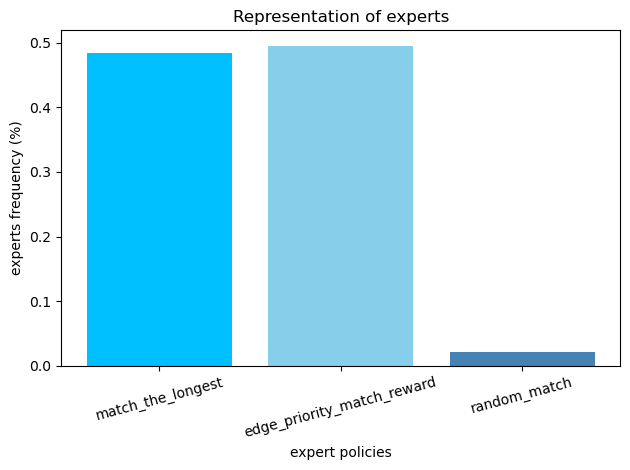

In [13]:
categories = list(experts_representation_dict.keys())
values = list(experts_representation_dict.values())
colors = ['deepskyblue', 'skyblue', 'steelblue']
# Create a bar graph
plt.bar(categories, values, color=colors)
plt.xlabel('expert policies')
plt.ylabel('experts frequency (%)')
plt.title('Representation of experts')

plt.xticks(rotation=15) 
plt.tight_layout()
plt.savefig('figures/weights_representation.png')

### Compute $V^\star$

In [14]:
%%time

# Initialize the value function


P, r = compute_transitions_and_rewards_actions()

# Perform value iteration
num_iterations = 1000
tolerance = 1e-5

policy = np.zeros(num_states, dtype=int)
V_star = np.zeros(num_states)

for i in range(num_iterations):
    delta = 0
    for s in range(num_states):
        v = V_star[s]
        #print(v)
        max_q_value = -np.inf
        best_expert = None
        for a in range(num_actions):
            if np.sum(P[s, a, :]) != 0:
                q_value = 0
                for prob, next_s, reward in zip(P[s, a], list(range(num_states)), r[s, a]):
                    q_value += prob * (reward + discount * V_star[next_s])
                if q_value > max_q_value:
                    max_q_value = q_value
                    best_expert = a
        V_star[s] = max_q_value
        #print(s, max_q_value, delta, v)
        policy[s] = best_expert
        delta = max(delta, abs(v - V_star[s]))
    
    print('delta -> ', delta)
    if delta < tolerance:
        break

delta ->  759.7834877860779
delta ->  199.93489458094965
delta ->  96.71979418005148
delta ->  54.652733913435185
delta ->  30.566306057649456
delta ->  17.393353319775542
delta ->  10.038206882758288
delta ->  5.98917728310596
delta ->  4.058163200488025
delta ->  2.7903340653776496
delta ->  1.9097748680645878
delta ->  1.3026711824024488
delta ->  0.8862606323757092
delta ->  0.6017452986554161
delta ->  0.40792385506638595
delta ->  0.2761868136131085
delta ->  0.1868072498142226
delta ->  0.12625153981984738
delta ->  0.08527042220660519
delta ->  0.05756145553220904
delta ->  0.0388399769480543
delta ->  0.026198348410161998
delta ->  0.017666235679399733
delta ->  0.011909993351409298
delta ->  0.008027762540208983
delta ->  0.00541013131007162
delta ->  0.0036455536757955542
delta ->  0.002456244144639186
delta ->  0.0016547793333074878
delta ->  0.0011147459416918082
delta ->  0.0007509041839313113
delta ->  0.0005057903646417117
delta ->  0.00034067305105622836
delta ->  0.00

In [15]:
P, r = compute_transitions_and_rewards_actions()

## Plots

In [16]:
V_exp = []
for i in range(num_exp):
    w = np.zeros(num_exp)
    w[i] = 1
    weights_exp = np.array([w]* num_states)
    P_avg, r_avg = compute_transitions_and_rewards_avg(weights_exp)
    V_exp.append(compute_value_bellman(P_avg, r_avg))

weights_dict_opt = np.zeros((num_states, num_exp))

for s in state_space_ind:
    w = np.zeros(num_exp)
    i = optimal_weights[int(s)]
    w[i] = 1
    weights_dict_opt[int(s)] = w
    
P_opt, r_opt = compute_transitions_and_rewards_avg(weights_dict_opt)
V_opt = compute_value_bellman(P_opt, r_opt)

118.59647583822104 match_the_longest
119.4463430359546 edge_priority_match_reward
118.11315475199848 random_match


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


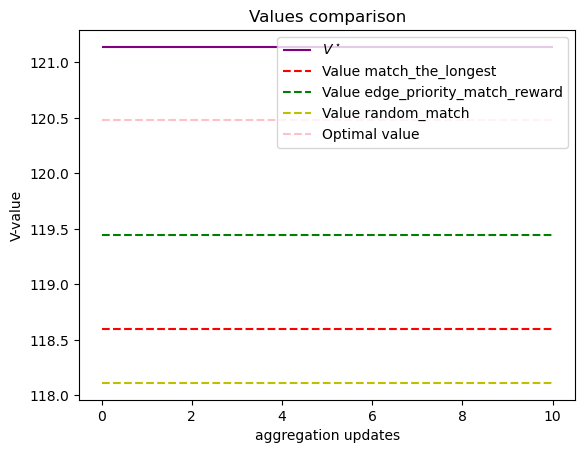

In [17]:
len_plot = 10
c = ['r', 'g', 'y', 'b']
count = 0

plt.hlines(V_star[0], 0, len_plot, 'purple', label = '$V^\star$')

for v, exp in zip(V_exp, experts):
    plt.hlines(v[0], 0, len_plot, c[count], linestyle='dashed', label = 'Value ' + exp)
    print(v[0], exp)
    count += 1
#plt.hlines(V_exp[2][0], 0, len(rewards_avg), c[count], linestyle='dashed', label = 'Value ' + exp)

#plt.hlines(V_opt[0], 0, len_plot, 'orange', label = 'Optimal value - check')
plt.hlines(V[0], 0, len_plot, 'pink','dashed', label = 'Optimal value')
plt.xlabel('aggregation updates')
plt.ylabel('V-value')
plt.title('Values comparison')
plt.legend()

plt.legend()
plt.savefig('figures/check_values.eps')

# Save Q

In [18]:
weights = np.array([np.ones(num_experts)/num_experts]*num_states)

P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
V_agg = compute_value_bellman(P_agg, r_agg)

Q_start = np.zeros((num_states, num_experts))
for state in range(num_states):
    Q_start[state, :] = V_agg[state] 
    
with open('Q/Q_start.pkl', 'wb') as output:
    pickle.dump(Q_start, output)

# Aggregation

## Import weights

In [74]:
# weights_expw = []
weights_OGD = []
weights_polpot = []
weights_expw_variable_eta = []
weights_expw_NN, weights_expw_NN1, weights_expw_NN2 = [], [], []
values_QL = []
values_QL1 = []

repeat_weights = 2

for n in range(repeat_weights):
#     with open('weights/weights_expw_' + str(n) + '.pkl', "rb") as fp:
#         weights_expw.append(pickle.load(fp))
    
    with open('weights/weights_expw_NN6' + str(n) + '.pkl', "rb") as fp:
        weights_expw_NN.append(pickle.load(fp))
        
    with open('weights/weights_expw_NN7' + str(n) + '.pkl', "rb") as fp: 
        weights_expw_NN1.append(pickle.load(fp))
        
    with open('weights/weights_expw_NN8' + str(n) + '.pkl', "rb") as fp: 
        weights_expw_NN2.append(pickle.load(fp))
        
        
    # with open('weights/weights_polpot_' + str(n) + '.pkl', "rb") as fp:
    #     weights_polpot.append(pickle.load(fp))
    # with open('weights/weights_expw_variable_eta_' + str(n) + '.pkl', "rb") as fp:
    #     weights_expw_variable_eta.append(pickle.load(fp))        
    # with open('weights/QL_' + str(n) + '.pkl', "rb") as fp:
    #     values_QL.append(pickle.load(fp)) 
    # with open('weights/QL1_' + str(n) + '.pkl', "rb") as fp:
    #     values_QL1.append(pickle.load(fp))
    #with open('weights_final/weights_OGD' + str(n) + '.pkl', "rb") as fp:
    #    weights_OGD.append(pickle.load(fp)) 

In [75]:
%%time

# rewards_agg_b_expw = []
rewards_agg_b_expw_NN, rewards_agg_b_expw_NN1, rewards_agg_b_expw_NN2 = [], [], []
rewards_agg_b_OGD = []
rewards_agg_b_polpot = []
rewards_agg_b_variable_eta = []

for n in range(repeat_weights):
    #print(n)
    
    # rewards_agg_b_expw.append([])
    rewards_agg_b_expw_NN.append([])
    rewards_agg_b_expw_NN1.append([])
    rewards_agg_b_expw_NN2.append([])
    rewards_agg_b_OGD.append([])
    rewards_agg_b_polpot.append([])
    rewards_agg_b_variable_eta.append([])
    
    #for updates, weights in weights_OGD[n].items():
    #    P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
    #    V_agg = compute_value_bellman(P_agg, r_agg)
    #    V_agg_pi0 = 0
    #    for i in range(len(verteces)):
    #        state = np.zeros(len(verteces))
    #        state[i] += 1
    #        ind = str(val_list.index(tuple(state)))
    #        V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
    #    rewards_agg_b_OGD[-1].append(V_agg_pi0)
        
    # for updates, weights in tqdm(weights_expw[n].items()):
    #     P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
    #     V_agg = compute_value_bellman(P_agg, r_agg)
    #     V_agg_pi0 = 0
    #     for i in range(len(verteces)):
    #         state = np.zeros(len(verteces))
    #         state[i] += 1
    #         ind = str(val_list.index(tuple(state)))
    #         V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
    #     rewards_agg_b_expw[-1].append(V_agg_pi0)
        
        
    for updates, weights in tqdm(weights_expw_NN[n].items()):
        P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
        V_agg = compute_value_bellman(P_agg, r_agg)
        V_agg_pi0 = 0
        for i in range(len(verteces)):
            state = np.zeros(len(verteces))
            state[i] += 1
            ind = str(val_list.index(tuple(state)))
            V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
        rewards_agg_b_expw_NN[-1].append(V_agg_pi0)
        
        
    for updates, weights in tqdm(weights_expw_NN1[n].items()):
        P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
        V_agg = compute_value_bellman(P_agg, r_agg)
        V_agg_pi0 = 0
        for i in range(len(verteces)):
            state = np.zeros(len(verteces))
            state[i] += 1
            ind = str(val_list.index(tuple(state)))
            V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
        rewards_agg_b_expw_NN1[-1].append(V_agg_pi0)
        
        
    for updates, weights in tqdm(weights_expw_NN2[n].items()):
        P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
        V_agg = compute_value_bellman(P_agg, r_agg)
        V_agg_pi0 = 0
        for i in range(len(verteces)):
            state = np.zeros(len(verteces))
            state[i] += 1
            ind = str(val_list.index(tuple(state)))
            V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
        rewards_agg_b_expw_NN2[-1].append(V_agg_pi0)
        
#     for updates, weights in tqdm(weights_polpot[n].items()):
#         P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
#         V_agg = compute_value_bellman(P_agg, r_agg)
#         V_agg_pi0 = 0
#         for i in range(len(verteces)):
#             state = np.zeros(len(verteces))
#             state[i] += 1
#             ind = str(val_list.index(tuple(state)))
#             V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
#         rewards_agg_b_polpot[-1].append(V_agg_pi0)
    
#     for updates, weights in tqdm(weights_expw_variable_eta[n].items()):
#         P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
#         V_agg = compute_value_bellman(P_agg, r_agg)
#         V_agg_pi0 = 0
#         for i in range(len(verteces)):
#             state = np.zeros(len(verteces))
#             state[i] += 1
#             ind = str(val_list.index(tuple(state)))
#             V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
#         rewards_agg_b_variable_eta[-1].append(V_agg_pi0)
        

100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.34it/s]

CPU times: user 2min 1s, sys: 2min 3s, total: 4min 5s
Wall time: 52.2 s


In [76]:
# mean
# rewards_expw_mean = np.mean(rewards_agg_b_expw, axis=0)
rewards_expw_NN_mean = np.mean(rewards_agg_b_expw_NN, axis=0)
rewards_expw_NN1_mean = np.mean(rewards_agg_b_expw_NN1, axis=0)
rewards_OGD_mean = np.mean(rewards_agg_b_OGD, axis=0)
rewards_polpot_mean = np.mean(rewards_agg_b_polpot, axis=0)
rewards_variable_eta_mean = np.mean(rewards_agg_b_variable_eta, axis=0)
# V_QL_mean = np.mean(values_QL, axis=0)
# V_QL_mean1 = np.mean(values_QL1, axis=0)

# std
# rewards_expw_std = np.std(rewards_agg_b_expw, axis=0)
rewards_expw_NN_std = np.std(rewards_agg_b_expw_NN, axis=0)
rewards_expw_NN1_std = np.std(rewards_agg_b_expw_NN1, axis=0)
rewards_OGD_std = np.std(rewards_agg_b_OGD, axis=0)
rewards_polpot_std = np.std(rewards_agg_b_polpot, axis=0)
rewards_variable_eta_std = np.std(rewards_agg_b_variable_eta, axis=0)
# V_QL_std = np.std(values_QL, axis=0)
# V_QL_std1 = np.std(values_QL1, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# Final Plot

## average over $\pi_0$

In [ ]:
V_star_pi0 = 0
for i in range(len(verteces)):
    state = np.zeros(len(verteces))
    state[i] += 1
    ind = str(val_list.index(tuple(state)))
    V_star_pi0 += prob_arrival[i] * V_star[int(ind)]
    #print(state_space_ind[ind])
    
V_opt_pi0 = 0
for i in range(len(verteces)):
    state = np.zeros(len(verteces))
    state[i] += 1
    ind = str(val_list.index(tuple(state)))
    V_opt_pi0 += prob_arrival[i] * V_opt[int(ind)]
    #print(state_space_ind[ind])

In [ ]:
V_exp_pi0 = {exp : 0 for exp in experts}
for v, exp in zip(V_exp, experts):
    for i in range(len(verteces)):
        state = np.zeros(len(verteces))
        state[i] += 1
        ind = str(val_list.index(tuple(state)))
        V_exp_pi0[exp] += prob_arrival[i] * v[int(ind)]
        #print(state_space_ind[ind])

## Plot

In [ ]:
values_list = []

updates_x = np.array(range(116)) * 30 #* 5000
updates_NN = np.array(range(7)) * 10 
updates_NN1 = np.array(range(34)) * 10 

updates_NN3 = np.array(range(14)) * 100 * 5000
# updates_ql = np.array(range(len(V_QL_mean))) * 100000

figure(figsize=(10, 8))


plt.hlines(V_star_pi0, 0, updates_x[-1], 'black',  linewidth=1.1, label = '$V^{\star}(\mu_0)$')
plt.hlines(V_opt_pi0, 0, updates_x[-1], 'black', ls ='dashdot',  linewidth=1.1, label = '$V_{q_\star\Pi}(\mu_0)$')


# ci_polpot = 2 * rewards_polpot_std #/ np.sqrt(10) 
# plt.plot(updates_x, rewards_polpot_mean, 'C2', linewidth=.8, label='$V_{\widetilde{q}_t\Pi}(\mu_0)$ (polynomial pot.)')
# plt.fill_between(updates_x, (rewards_polpot_mean-ci_polpot), (rewards_polpot_mean+ci_polpot), color='C2', alpha=.1)

# ci_exp_var = 2 * rewards_variable_eta_std 
# plt.plot(updates_x, rewards_variable_eta_mean , 'C3',linewidth=.8,  label='$V_{\widetilde{q}_t\Pi}$ (exponential pot. $\eta_t$)')
# plt.fill_between(updates_x, (rewards_variable_eta_mean -ci_exp_var), (rewards_variable_eta_mean  +ci_exp_var), color='C3', alpha=.1)

#ci_OGD = 2 * rewards_OGD_std 
#plt.plot(updates_x[:68], rewards_OGD_mean , 'C4',linewidth=.8,  label='$V_{\widetilde{q}_t\Pi}$ (greedy projection)')
#plt.fill_between(updates_x[:68], (rewards_OGD_mean -ci_OGD), (rewards_OGD_mean + ci_OGD), color='C4', alpha=.1)

# ci_expw = 2 * rewards_expw_std 
# plt.plot(updates_x, rewards_expw_mean, 'C0',linewidth=.8,  label='$V_{\widetilde{q}_t\Pi}$ (exponential pot. $\eta$ fixed)')
# plt.fill_between(updates_x, (rewards_expw_mean -ci_expw), (rewards_expw_mean +ci_expw), color='C0', alpha=.1)

# ci_expw_NN = 2 * rewards_expw_NN_std
# plt.plot(updates_NN, rewards_expw_NN_mean, 'red',linewidth=.8,  label='$V_{\widetilde{q}_t\Pi}$ (exponential pot. NN)')
# plt.fill_between(updates_NN, (rewards_expw_NN_mean -ci_expw_NN), (rewards_expw_NN_mean +ci_expw_NN), color='C0', alpha=.1)


# ci_expw_NN1 = 2 * rewards_expw_NN1_std
# plt.plot(updates_NN1, badNN, 'green',linewidth=.8,  label='$V_{\widetilde{q}_t\Pi}$ (exponential pot. NN)')
# plt.fill_between(updates_NN1, (badNN -ci_expw_NN1), (badNN +ci_expw_NN1), color='C0', alpha=.1)

for i, rewards in enumerate(rewards_agg_b_expw_NN):
    if i == 0:
        plt.plot(updates_NN1, rewards, 'red', linewidth=.8, label='50 x 200 it')
    else:
        plt.plot(updates_NN1, rewards, 'red', linewidth=.8)
    
        
for i, rewards in enumerate(rewards_agg_b_expw_NN1):
    if i == 0:
        plt.plot(updates_NN, rewards, 'green', linewidth=.8, label='50 x 100 it')
    else:
        plt.plot(updates_NN, rewards, 'green', linewidth=.8)
        
        
for i, rewards in enumerate(rewards_agg_b_expw_NN2):
    if i == 0:
        plt.plot(updates_NN, rewards, 'blue', linewidth=.8, label='200 x 100 it')
    else:
        plt.plot(updates_NN, rewards, 'blue', linewidth=.8)
        

c = ['dimgrey', 'darkgrey', 'lightgrey']
count = 0
 
    
V_exp_sorted = sorted(V_exp_pi0.items(), key=lambda x:x[1], reverse= True)

for item in V_exp_sorted:
    plt.hlines(item[1], 0, updates_x[-1], c[count], linestyle='dashed', linewidth=1.1, label = '$V_{\pi_' + str(exp_ind[item[0]] +1 ) + '}(\mu_0)$')
    count += 1
    


# ci_QL = 1.96 * V_QL_std / np.sqrt(10)
# plt.plot(updates_ql, V_QL_mean, 'C4',linewidth=.8,  label='$V_{QL}$')
# plt.fill_between(updates_ql, (V_QL_mean-ci_QL), (V_QL_mean+ci_QL), color='C4', alpha=.1)

# ci_QL1 = 1.96 * V_QL_std1 / np.sqrt(10)
# plt.plot(updates_ql, V_QL_mean1, 'C5',linewidth=.8,  label='$V_{QL1}$')
# plt.fill_between(updates_ql, (V_QL_mean1-ci_QL1), (V_QL_mean1+ci_QL1), color='C5', alpha=.1)

#plt.plot(Q_evolution[0: len(updates_x)], label='QL')

plt.xlabel('$t$', fontsize=16)
plt.ylabel('V-value', fontsize=16)
plt.xlim((0, 500))
#plt.ylim((1.08, 1.09))
#plt.title('Values comparison')
plt.legend(loc='lower right', fontsize=16)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('figures/comp_agg_QL_new_9.pdf')